In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pprint
import scipy
import tensorflow as tf

from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Normal, MultivariateNormalTriL

In [2]:
class FLAGS:
    N=1000   # Number of data points
    D=5     # Number of features
    N_CUT=5

In [3]:
def build_toy_dataset(N, D, noise_std=1, max_level=FLAGS.N_CUT):
    X = np.random.uniform(-6, 6, size=(N, D))
    w = np.random.uniform(-1, 1, size=D)
    epsilon = np.random.normal(0, noise_std, size=N)
    
    # levels will be 0, 1, ..., max_level
    levels = np.array(range(max_level))

    # note, due to gaussian noise, this is not generated from ordered logit model
    thresholds = levels[:,np.newaxis]
    logits = np.dot(X, w) + epsilon
    y = (logits > thresholds).astype(int).sum(axis=0)
    # level is the last TRUE in each row, which is also the row sum
    
    return X, y

In [4]:
from edward.models import RandomVariable
from tensorflow.python.framework import dtypes
from tensorflow.contrib.distributions import Distribution, NOT_REPARAMETERIZED

class distributions_OrdinalLogit(Distribution):
    def __init__(self, logits, cutpoints, name="OrdinalLogit"):
        self._logits = logits
        self._cutpoints = cutpoints
        
        parameters = dict(locals())
        super(distributions_OrdinalLogit, self).__init__(
            dtype=dtypes.int32,
            reparameterization_type=NOT_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=parameters,
            graph_parents=[self._logits, self._cutpoints],
            name=name
        )

    def _data_size(self):
        return tf.size(self._logits)
        
    def _cumul_probs(self):
        logits_with_cutpoints = tf.expand_dims(self._logits, -1) + self._cutpoints  # using broadcasting
        return tf.sigmoid(logits_with_cutpoints)
        
    def _log_prob(self, value):        
        cumul_probs = self._cumul_probs()
        level_probs = tf.concat([cumul_probs, tf.expand_dims(tf.ones([self._data_size()]), -1)], axis=1) - \
                        tf.concat([tf.expand_dims(tf.zeros([self._data_size()]), -1), cumul_probs], axis=1)
        levels = value
        indices_2d = tf.transpose(tf.stack([tf.range(self._data_size()), levels]))  # n x 2
        selected_probs = tf.gather_nd(level_probs, indices_2d)
        
        return tf.reduce_sum(tf.log(selected_probs))
    
    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        new_shape = [n, self._data_size()]
        sample_probs = tf.expand_dims(tf.random_uniform(new_shape), -1)
        booleans = tf.greater(sample_probs, cumul_probs)  # using broadcasting
        samples = tf.reduce_sum(tf.cast(booleans, dtype=dtypes.int32), axis=-1)
        return samples
    
    def mean(self):
        # Using the identity that the mean is \sum_{i=0}^k P(X > i)
        cumul_probs = self._cumul_probs()
        means = tf.reduce_sum(1-cumul_probs, axis=1)
        return means
        

def __init__(self, *args, **kwargs):
    RandomVariable.__init__(self, *args, **kwargs)

_name = 'OrdinalLogit'
_candidate = distributions_OrdinalLogit
__init__.__doc__ = _candidate.__init__.__doc__
_globals = globals()
_params = {'__doc__': _candidate.__doc__,
           '__init__': __init__,
           'support': 'countable'}
_globals[_name] = type(_name, (RandomVariable, _candidate), _params)

In [5]:
ed.set_seed(42)

# DATA
X_all, y_all = build_toy_dataset(2*FLAGS.N, FLAGS.D)

test_cutpoints = np.linspace(-1, 1, FLAGS.N_CUT)

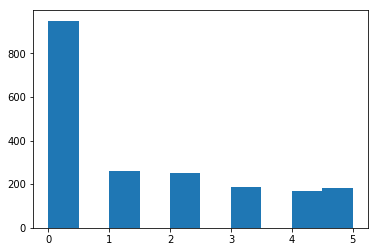

In [6]:
plt.hist(y_all)
plt.show()

In [7]:
X_train, X_rest, y_train, y_rest = train_test_split(X_all, y_all, train_size=FLAGS.N)

# MODEL
X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
# b = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
# y = Bernoulli(logits=ed.dot(X, w) + b)

cutpoints = tf.placeholder(tf.float32, [FLAGS.N_CUT])
logits = ed.dot(X, w)
y = OrdinalLogit(
    logits=logits, 
    cutpoints=cutpoints, 
    value=tf.cast(tf.zeros_like(logits), tf.int32)    # avoid sample_n call since we get this error:
    # InvalidArgumentError (see above for traceback):  : Tensor had NaN values
    # [[Node: inference_1/VerifyFinite_1/CheckNumerics = CheckNumerics[T=DT_FLOAT, _class=["loc:@Normal/sample/Reshape"], message="", _device="/job:localhost/replica:0/task:0/device:CPU:0"](PointMass_1/sample/Reshape)]]
)   # b gets absorbed into cutpoints

# INFERENCE
# qb = Normal(
#     loc=tf.Variable(tf.zeros([1])), 
#     scale=tf.Variable(tf.ones([1])))  # should probably initialize to random values

qw = MultivariateNormalTriL(
    loc=tf.Variable(tf.random_normal([FLAGS.D])),
    scale_tril=tf.Variable(tf.random_normal([FLAGS.D, FLAGS.D])))

inference = ed.Laplace({w: qw}, data={X: X_train, y: y_train, cutpoints: test_cutpoints})
inference.initialize(n_print=10, n_iter=600)

inference.run()


/Users/cyz/edward/edward/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 1444.813


In [8]:
# Hmm, is this due to bug or lack of prior on cutpoints?
# Replicate Bernoulli with OrdinalLogit...
# Wait, no error anymore!
# Should still replicate result with Bernoulli as a sanity check.

In [9]:
# these give same result
qw.scale.to_dense().eval()
tf.cholesky(qw.covariance()).eval()

array([[ 1.6980482e-02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 1.4069458e-03,  1.7247109e-02,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 2.3951593e-03,  3.3402701e-03,  1.8310523e-02,  0.0000000e+00,
         0.0000000e+00],
       [ 2.3831542e-04, -8.8704802e-04, -2.5479004e-03,  1.7532619e-02,
         0.0000000e+00],
       [-1.2956447e-05,  1.3881541e-04, -3.5206816e-04, -3.0495410e-04,
         1.6999261e-02]], dtype=float32)

In [10]:
# this is inverse of observed Fisher information, used in Laplace approximation
qw.covariance().eval()

array([[ 2.8833677e-04,  2.3890618e-05,  4.0670962e-05,  4.0467107e-06,
        -2.2000671e-07],
       [ 2.3890618e-05,  2.9944227e-04,  6.0979863e-05, -1.4963717e-05,
         2.3759353e-06],
       [ 4.0670962e-05,  6.0979863e-05,  3.5216945e-04, -4.9045568e-05,
        -6.0139041e-06],
       [ 4.0467107e-06, -1.4963717e-05, -4.9045568e-05,  3.1472815e-04,
        -4.5758329e-06],
       [-2.2000671e-07,  2.3759353e-06, -6.0139041e-06, -4.5758329e-06,
         2.8921128e-04]], dtype=float32)

In [11]:
qw.mean().eval()

array([ 0.12267312,  0.17115007,  0.3390169 , -0.12927967,  0.00511184],
      dtype=float32)

In [12]:
# qb.scale.eval()

In [13]:
# qb.loc.eval()

In [14]:
obs_fisher = np.linalg.inv(qw.covariance().eval()) / FLAGS.N

In [15]:
print(obs_fisher)

[[ 3.5420072  -0.20911463 -0.38912386 -0.11620396 -0.00551768]
 [-0.20911463  3.4760346  -0.5674161   0.07896247 -0.03926509]
 [-0.38912386 -0.5674161   3.0472353   0.4539797   0.07491288]
 [-0.11620396  0.07896247  0.4539797   3.2542145   0.06019045]
 [-0.00551768 -0.03926509  0.07491288  0.06019045  3.4605083 ]]


In [16]:
# y.log_prob requires argument of length y
# construct a new variable representing candidate from y_rest
# compute likelihood with autodiff

X = tf.placeholder(tf.float32, [1, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
y = OrdinalLogit(logits=ed.dot(X, w), cutpoints=cutpoints)   # b gets absorbed into cutpoints

In [17]:
y_next = tf.get_variable("y_next", [1], dtype=dtypes.int32)

In [18]:
y_next_hess = tf.hessians(y.log_prob(y_next.value()), w)[0]

In [19]:
w_map = qw.mean().eval()

In [20]:
# observed Fisher information, see https://en.wikipedia.org/wiki/Observed_information
def new_point_info(X_new, y_new):
    return -y_next_hess.eval(feed_dict={X: X_new, w: w_map, cutpoints: test_cutpoints, y_next: y_new})

# actual Fisher information (expectation taken over y_new)
# TODO: make this more efficient (e.g. don't run all calls to new_point_info in separate sessions)
def new_point_info_expected(X_new):
    # integrate out y_next
    cumul_probs = y._cumul_probs().eval(feed_dict={X: X_new, w: w_map, cutpoints: test_cutpoints})[0]
    probs = np.append(cumul_probs, 1) - np.append(0, cumul_probs)
    levels = np.arange(probs.size)
    info_per_level = np.array([new_point_info(X_new, [level]) for level in levels])
    return probs[:,np.newaxis,np.newaxis] * info_per_level

## TODO: should initialize to the prior precision
obs_fisher_2 = np.zeros((FLAGS.D, FLAGS.D))
for i in range(len(X_train)):
    obs_fisher_2 += new_point_info(X_train[[i]], y_train[[i]])

In [21]:
obs_fisher_2 / FLAGS.N

array([[ 3.46716672, -0.28291825, -0.40205225, -0.11988337, -0.0055238 ],
       [-0.28291825,  3.38384442, -0.58046724,  0.09074351, -0.03825025],
       [-0.40205228, -0.58046724,  3.14010583,  0.43257301,  0.07724843],
       [-0.11988333,  0.09074349,  0.43257302,  3.32125017,  0.06772527],
       [-0.00552376, -0.03825023,  0.0772485 ,  0.06772528,  3.462631  ]])

In [22]:
# Now let's implement item selection.

In [23]:
from collections import namedtuple

OptCriteria = namedtuple('OptCriteria', ['trace', 'logdet', 'max_eigval'])

# Lambda is the precision matrix
# return measures of the variance, Lambda^{-1}
def compute_opt_criteria(Lambda):
    eigvals_Lambda = np.linalg.eigvals(Lambda)
    # When there are not enough previous questions for full rank,
    # some eigenvalues will be 0. Ensure numerical stability here.
    # Originally chose threshold 1e-8, but sometimes an eigenvalue
    # that should've been 0 exceeded this threshold.
    # TODO: handle in a safer way.
    eigvals_Lambda[eigvals_Lambda < 1e-6] = 1e-6
    eigvals_Var = 1.0 / eigvals_Lambda
    return OptCriteria(
        trace = np.sum(eigvals_Var),
        logdet = np.sum(np.log(eigvals_Var)),
        max_eigval = np.max(eigvals_Var)
    )

opt_criteria_comparators = dict(
    A = lambda o1, o2: o1.trace - o2.trace,
    D = lambda o1, o2: o1.logdet - o2.logdet,
    E = lambda o1, o2: o1.max_eigval - o2.max_eigval
)

def cmp_criteria_for(optimality_type):
    return opt_criteria_comparators[optimality_type]


In [24]:
Lambda_prev = obs_fisher_2
best_new, best_opt_criteria = None, None
cmp_criteria = cmp_criteria_for('A')

for i in range(min(100, FLAGS.N)):
    X_cand = X_rest[[i]]
    Lambda_cand = Lambda_prev + new_point_info_expected(X_cand)
    opt_criteria = compute_opt_criteria(Lambda_cand)
    
    if best_opt_criteria is None or cmp_criteria(opt_criteria, best_opt_criteria) < 0:
        best_new = i
        best_opt_criteria = opt_criteria

In [25]:
best_new, X_rest[[best_new]], y_rest[[best_new]]

(57,
 array([[ 3.72820284,  5.38043463, -4.90409119, -4.06262777,  5.52895563]]),
 array([0]))